In [1]:
# Cell 1 - Imports & load
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# show plots inline (not required in VS Code notebook but safe)
%matplotlib inline

# load dataset (path relative to notebook)
df = pd.read_csv("data/OnlineRetail.csv", encoding="ISO-8859-1")

print("Shape of dataset:", df.shape)
display(df.head())
print("\nColumn info:")
print(df.info())
print("\nMissing values per column:")
print(df.isnull().sum())


Shape of dataset: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom



Column info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
None

Missing values per column:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [2]:
# Step 2: Data Cleaning

# Make a copy to keep original safe
df_clean = df.copy()

# 1. Convert InvoiceDate to datetime
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'], errors='coerce')

# 2. Ensure Quantity and UnitPrice are numeric
df_clean['Quantity'] = pd.to_numeric(df_clean['Quantity'], errors='coerce')
df_clean['UnitPrice'] = pd.to_numeric(df_clean['UnitPrice'], errors='coerce')

# 3. Create a new column: Total Sales
df_clean['Sales'] = df_clean['Quantity'] * df_clean['UnitPrice']

# 4. Remove duplicates
df_clean.drop_duplicates(inplace=True)

# 5. Remove rows with non-positive Quantity or UnitPrice (to exclude returns/invalid entries)
df_clean = df_clean[(df_clean['Quantity'] > 0) & (df_clean['UnitPrice'] > 0)]

# Quick check after cleaning
print("Shape after cleaning:", df_clean.shape)
print("\nMissing values per column:")
print(df_clean.isnull().sum())


Shape after cleaning: (524878, 9)

Missing values per column:
InvoiceNo           0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     132186
Country             0
Sales               0
dtype: int64


In [3]:
# Step 3: Descriptive Statistics

# Basic stats for Quantity, UnitPrice, Sales
desc_stats = df_clean[['Quantity', 'UnitPrice', 'Sales']].agg(['mean', 'median', 'std']).T
desc_stats['mode'] = df_clean[['Quantity', 'UnitPrice', 'Sales']].mode().iloc[0]
display(desc_stats)

# Top 10 products by total sales
top_products = (
    df_clean.groupby('Description')['Sales']
    .sum()
    .sort_values(ascending=False)
    .head(10)
)
print("\nTop 10 products by total sales:")
display(top_products)


,mean,median,std,mode
Quantity,10.616600,4.00,156.280031,1.00
UnitPrice,3.922573,2.08,36.093028,1.25
Sales,20.275399,9.92,271.693566,15.00



Top 10 products by total sales:


Description
DOTCOM POSTAGE                        206248.77
REGENCY CAKESTAND 3 TIER              174156.54
PAPER CRAFT , LITTLE BIRDIE           168469.60
WHITE HANGING HEART T-LIGHT HOLDER    106236.72
PARTY BUNTING                          99445.23
JUMBO BAG RED RETROSPOT                94159.81
MEDIUM CERAMIC TOP STORAGE JAR         81700.92
POSTAGE                                78101.88
Manual                                 77752.82
RABBIT NIGHT LIGHT                     66870.03
Name: Sales, dtype: float64

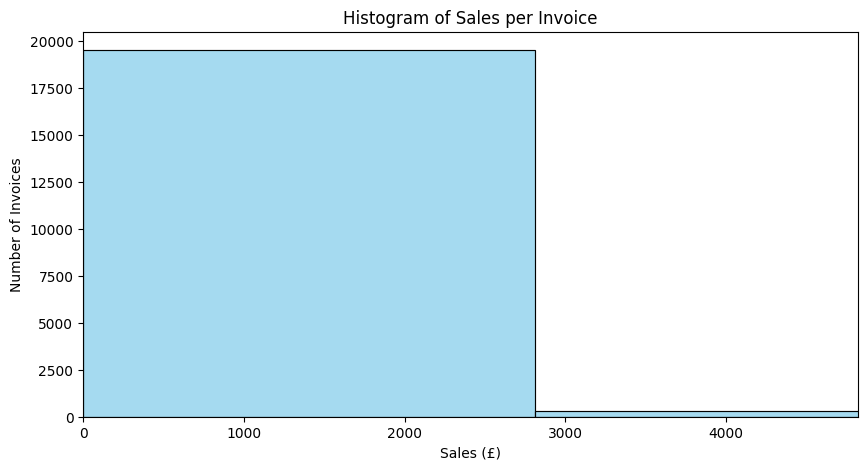

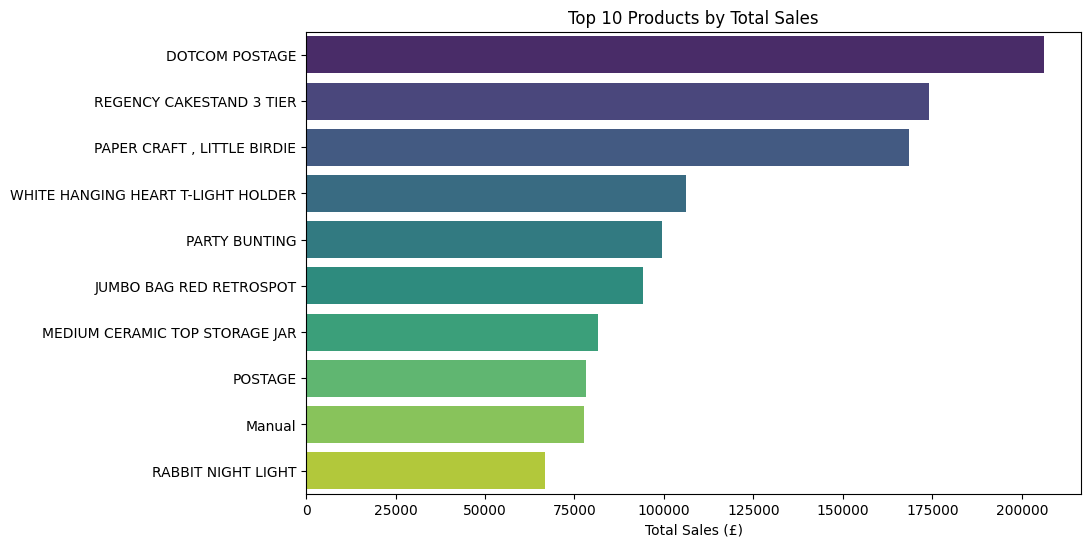

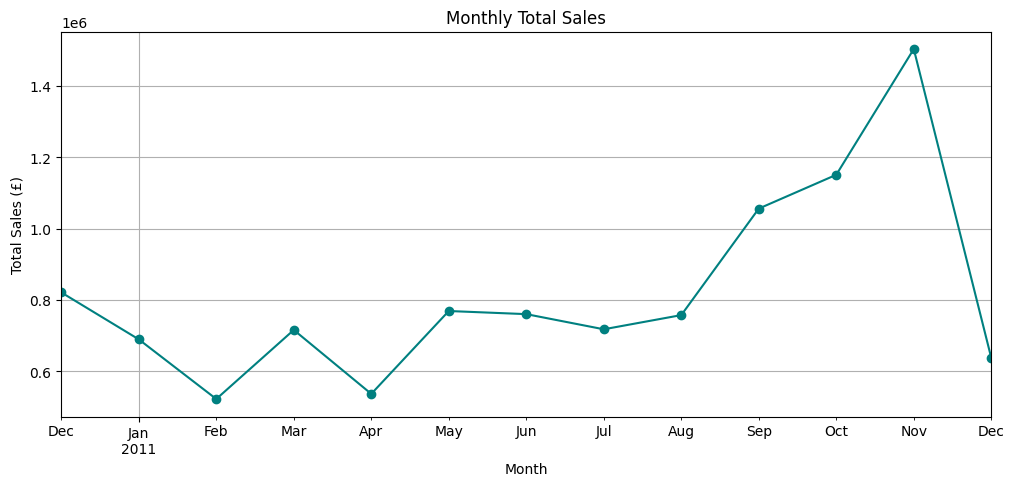

In [6]:
# Step 4: Visualizations (clean version)

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Histogram: Sales per invoice
plt.figure(figsize=(10,5))
sales_per_invoice = df_clean.groupby('InvoiceNo')['Sales'].sum()
sns.histplot(data=sales_per_invoice.to_frame(name="Sales"), x="Sales", bins=60, kde=False, color="skyblue")
plt.xlim(0, sales_per_invoice.quantile(0.99))  # cut off top 1% to reduce skew
plt.title("Histogram of Sales per Invoice")
plt.xlabel("Sales (£)")
plt.ylabel("Number of Invoices")
plt.show()

# 2. Bar chart: Top 10 products by sales
plt.figure(figsize=(10,6))
sns.barplot(
    data=top_products.reset_index(),
    y="Description", x="Sales", hue="Description", palette="viridis", dodge=False, legend=False
)
plt.title("Top 10 Products by Total Sales")
plt.xlabel("Total Sales (£)")
plt.ylabel("")
plt.show()

# 3. Line chart: Sales over time (monthly)
monthly_sales = df_clean.set_index('InvoiceDate').resample('ME')['Sales'].sum()  # 'ME' = month-end
plt.figure(figsize=(12,5))
monthly_sales.plot(marker='o', color="teal")
plt.title("Monthly Total Sales")
plt.xlabel("Month")
plt.ylabel("Total Sales (£)")
plt.grid(True)
plt.show()
